## Setup

In [2]:
%pip install hdbscan

Note: you may need to restart the kernel to use updated packages.


In [3]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os;

os.environ["ACCELERATE_ENABLE_RICH"] = "0"

os.environ['WANDB_NOTEBOOK_NAME'] = os.path.basename(globals()['__vsc_ipynb_file__']) 

# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


import sys
from functools import partial
import json
from typing import List, Tuple, Union, Optional, Callable, Dict
import torch as t
from torch import Tensor
from sklearn.linear_model import LinearRegression
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import einops
from tqdm import tqdm
from jaxtyping import Float, Int, Bool
from pathlib import Path
import pandas as pd
import circuitsvis as cv
import webbrowser
from IPython.display import display
from transformer_lens import utils, ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.components import LayerNorm
from eindex import eindex

import functools
import matplotlib.pyplot as plt

# t.set_grad_enabled(False)

# Make sure exercises are in the path
chapter = r"chapter1_transformers"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "monthly_algorithmic_problems" / "september23_sum"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from monthly_algorithmic_problems.september23_sum.model import create_model
from monthly_algorithmic_problems.september23_sum.training import train, TrainArgs
from monthly_algorithmic_problems.september23_sum.dataset import SumDataset,Pairs
from plotly_utils import hist, bar, imshow

# Running this on a macbook air and mps is flaky
device = t.device("cpu") #t.device("cuda" if t.cuda.is_available() else "cpu")


MAIN = __name__ == "__main__"

## Dataset

-- Note: I rewrote the Dataset class so that it balances no carry, plain carry and cascading carry  classes evenly. this puts a larger emphasis difficult cases relative to the original way this dataset was written. With random additions, cascading carry is an edge case that is quite infrequent. 

-- I added a "START" token under the premise that it functions as an attention sink https://arxiv.org/pdf/2309.17453.pdf
In truth, I really need to do more experiments to justify this. 

In [4]:
dataset = SumDataset(size=5000, num_digits=4).to(device)

## Transformer

-- After doing this excercise, I also wanted to modify the attention mask because as you can see below, the loss function is only being calculated on the last num_digits. 

    def _shared_train_validation_step(self, toks: Tensor) -> Tuple[Tensor, Tensor]:
        toks = toks.to(self.args.device)
        logits = self.model(toks)[:, -(self.args.num_digits+1):-1]
        target = toks[:, -self.args.num_digits:]
        return logits, target

-- FYI: I removed the weight_decay while I was playing around with adding a different form of regularization (minimizing the loss as a sum of covariance between activations of attention heads). I'm not including results from these tests at this point as there was a bit more work to do on it before I could make sense of the results. 

In [5]:
filename = section_dir / "sum_model_normal.pt" # note this was trained on a mac in cpu mode without cuda and mps
args = TrainArgs(
    num_digits=4,
    trainset_size=100_000,
    valset_size=5_000,
    epochs=100,
    batch_size=512,
    lr_start=2e-3,
    lr_end=1e-4,
    # weight_decay=0.001, # not weight decay, could add this back in 
    weight_decay=0.00,
    seed=42,
    d_model=48,
    d_head=24,
    n_layers=2,
    n_heads=3,
    d_mlp=None,
    normalization_type="LN",
    use_wandb=True,
    device=device,
    # corr_loss=CorrLoss(rank=2) # add this to add in a loss function of rank=2 for the correlation between activations on different attention heads
)
model = create_model(
    num_digits=4,
    seed=0,
    d_model=48,
    d_head=24,
    n_layers=2,
    n_heads=3,
    normalization_type="LN",
    d_mlp=None,
    device=device
)
model.load_state_dict(t.load(filename))

# model = train(args)
# t.save(model.state_dict(), filename)

<All keys matched successfully>

# This is the dataset I'll use for the experiments below. 
- 1000 examples
- Note: there is also data that tells you if a particular digit is carrying or if its a cascading carry

In [6]:
dataset  = SumDataset(size=1000, num_digits=4)
print(dataset[0])
reference = SumDataset(size=10 , num_digits=4)


# Pairs shows you the case that the token sequence is testing 
# - a 0 means no carry
# - a 1 means a '9' (which will trigger a cascading carry if there is a carry on the prior digit)
# - a 2 means that the digit carrys over ot hte nest digit
# [ 0 0 2 0 ] means no carry in the 1000s, 100s, 1s digit, while a carry in the 10s digit
i = dataset.p[0].item()
print(Pairs.p[i])
print(dataset.toks.shape)

tensor([12,  3,  1,  9,  0, 10,  4,  5,  7,  7, 11,  7,  7,  6,  7])
[0 0 2 0]
torch.Size([1000, 15])


## Code to do ablation runs

-- The code below works, but the data structure I'm putting the results in is so unnecssarily complicated. It should be rewritten

In [99]:
from torch.utils.data import Dataset
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap


def input_word_ablation_hook(resid_pre: Float[Tensor, "batch seq d_model"],hook: HookPoint,replacement_value,input_word: int) -> Float[Tensor, "batch seq d_model"]:
    resid_pre[:, input_word, :] = replacement_value
    return resid_pre

def input_word_hook( replacement_value, input_word) :
    return functools.partial(input_word_ablation_hook,replacement_value=replacement_value,input_word=input_word)

def lh_word_ablation_hook(result: Float[Tensor, "batch seq head_idx d_model"],hook: HookPoint,replacement_value,head: int,lh_word: int) -> Float[Tensor, "batch seq head_idx d_model"]:
    result[:, lh_word, head, :] = replacement_value
    return result

def lh_word_hook( replacement_value, head, lh_word) :
    return functools.partial(lh_word_ablation_hook,replacement_value=replacement_value, head=head, lh_word=lh_word)


def l_attn_ablation_hook(resid_post: Float[Tensor, "batch seq d_model"],hook: HookPoint,replacement_value,lh_word: int) -> Float[Tensor, "batch seq d_model"]:
    resid_post[:, lh_word, :] = replacement_value
    # resid_post[:, 0,  :] = resid_post[:, 0,  :].mean(0,keepdim=True)
    # resid_post[:, 14, :] = resid_post[:, 14,  :].mean(0,keepdim=True)
    return resid_post

def l_attn_hook( replacement_value, lh_word) :
    return functools.partial(l_attn_ablation_hook,replacement_value=replacement_value, lh_word=lh_word)

# pass in dataset.toks
class Ablation() :
    def __init__(self, model : HookedTransformer, dataset : Dataset, pred_i : List[int] = [10,11,12,13] , reference : Dataset = None ) :
        self.model   = model
        self.dataset = dataset
        self.layers  = model.cfg.n_layers
        self.heads   = model.cfg.n_heads
        self.words   = model.cfg.n_ctx
        self.ndims   = model.cfg.d_model
        self.pred_i  = pred_i
        self.reference = reference 

        model.reset_hooks()
        self.ctrl_logits,self.ctrl_cache  = model.run_with_cache(dataset)
        self.ctrl_preds = self.ctrl_logits.softmax(dim=-1).argmax(dim=-1)
        model.reset_hooks()


        self.calc()


    def calc(self) :    

        if self.reference is not None :
            model.reset_hooks()
            self.ref_logits,self.ref_cache  = model.run_with_cache( reference )
            self.ref_preds = self.ref_logits.softmax(dim=-1).argmax(dim=-1)
            model.reset_hooks()
            self.ref_length = reference.shape[0]
        else :
            self.ref_length = 1

        self.tr_cache     = self.trace_inputs()

        self.X = t.zeros( (self.ref_length, self.dataset.shape[0], len(self.pred_i), self.layers, self.heads, self.words, self.words), dtype= t.int)

        self.ablate()



    def trace_inputs(self) :
        return { (ref, layer, input_word )  : self.calc_trace(ref, layer, input_word ) for ref in range(self.ref_length) for layer in range(self.layers)  for input_word in  range(self.words) }
 
    def ablate(self):
        [ self.calc_preds(ref, layer, head, lh_word, input_word ) for ref in range(self.ref_length) for layer in range(self.layers) for head in range(self.heads) for lh_word in self.layer_wordrange(layer) for input_word in  range(lh_word+1) ]

    def layer_wordrange(self, layer) :
        return range(self.words) if layer < self.layers else self.pred_i
    
    def calc_trace(self,ref, layer, input_word) :

        if self.reference is None :
            replacement_value = self.ctrl_cache["resid_pre", layer][:,input_word,:].mean(0,keepdim=True)
        else :
            replacement_value = self.ref_cache["resid_pre", layer][ ref ,input_word,:].unsqueeze(0)

        self.model.reset_hooks()
        self.model.add_hook( utils.get_act_name("resid_pre", layer), input_word_hook( replacement_value ,input_word)  )
        _ , t_cache = self.model.run_with_cache(self.dataset)
        self.model.reset_hooks()
        return t_cache

    def calc_preds(self,ref, layer, head, lh_word, input_word) :


        replacement_value = self.tr_cache[(ref,layer,input_word)]["result" , layer][:, lh_word, head, :]
        # ctrl_value        = self.ctrl_cache["result" , layer][:, lh_word, head, :]

        self.model.reset_hooks()
        self.model.add_hook( utils.get_act_name("result", layer), lh_word_hook( replacement_value, head, lh_word)  )
        logits_ablate, _ = model.run_with_cache(self.dataset)
        self.model.reset_hooks()

        #self.X = t.zeros( (dataset.toks.shape[0], len(self.pred_i), self.layers, self.heads, self.words, self.words), dtype= t.int)
        preds = logits_ablate.softmax(dim=-1).argmax(dim=-1)

        for index, outcome_word in enumerate(self.pred_i) :
            self.X[ ref, self.errors( preds, outcome_word), index ,layer, head,lh_word,input_word] = 1

        return None

    def errors(self, preds, outcome_word) :
        return self.ctrl_preds[:,outcome_word] != preds[:,outcome_word]
        # return t.nonzero(self.ctrl_preds[:,outcome_word] != preds[:,outcome_word]).flatten()
    

    def visualize(self, title=None , outcome_words = None, labels=None, indices=None, ref = -1 , pr=False , layers = None) :
        outcome_words = outcome_words or [0,1,2,3]
        if (layers is None) :
            layers = [ i in range(self.layers)]

        if (indices is None) :
            indices    = t.ones(self.X.shape[1], dtype=t.bool)
        sz  = indices.sum().item()


        def make_array( layer, head , outcome_word ) :
            arr = np.zeros((self.words,self.words),dtype=float)
            for lh_word in range(self.words) :
                for input_word in range(lh_word+1) :
                    if (ref < 0 ) :
                        arr[input_word,lh_word] = self.X[ : , indices,outcome_word,layer,head,lh_word,input_word].sum() / (sz*self.X.shape[0])
                    else :
                        arr[input_word,lh_word] = self.X[ ref , indices,outcome_word,layer,head,lh_word,input_word].sum() / sz
                    if (pr == True and arr[input_word,lh_word] > 0.005) :
                        print(layer, head, input_word, lh_word ,arr[input_word,lh_word])
            return arr

        fig, axs = plt.subplots(len(layers),self.heads, figsize=(self.heads*3.5,len(layers)*3.5))
        fig.subplots_adjust(wspace=0.05, hspace=0.05)
        if title is not None :
            fig.suptitle(title)

        cmaps = [ 'Reds','Blues','Purples','Greens']

        for layer in layers:
            for head in range(self.heads):
                arr = []
                for digit in outcome_words :
                    arr.append(  make_array( layer, head, digit )  )

                ax = axs[layer, head] if len(layers) > 1 else axs[head]

                ax.set_title(f'Layer {layer}, Head {head}')
                ax.set_yticks(np.arange(-.5, self.words-.5,1), minor=True)
                ax.set_yticks(np.arange(self.words), minor=False)

                if (head==0) :
                    ax.set_ylabel('Inputted Words')
                    if (labels is not None) :
                        ax.set_yticklabels(labels)
                else :
                    ax.set_yticklabels([])

                if (layer == len(layers)-1) :
                    ax.set_xlabel('\"Result\" words')
                    

                ax.set_xticks(np.arange(-.5, self.words-.5,1), minor=True)
                ax.set_xticks(np.arange(0,self.words,1), minor=False)
                if (labels is not None) :
                    ax.set_xticklabels(labels)
                
                ax.invert_yaxis()

                # Draw horizontal grid lines
                ax.hlines(np.arange(-.5, self.words-.5,1), *ax.get_xlim(), color='grey', linewidth=1)
                # Draw vertical grid lines
                ax.vlines(np.arange(-.5, self.words-.5,1), *ax.get_ylim(), color='grey', linewidth=1)

                def offset(d_in,i,j) :
                    off = False
                    for dd in range(d_in) :
                        if arr[dd][i,j] > 0.005 :
                            off = True
                            break
                    return off
                
                cax = ax.imshow(np.zeros((self.words,self.words),dtype=float), cmap='Greys',aspect='equal',vmin=0,vmax=1)
                for i in range(arr[0].shape[0]):
                    for j in range(arr[0].shape[1]):
                        for d in range(len(outcome_words)) : 
                            cmap = plt.get_cmap(cmaps[d]) 
                            if (arr[d][i,j]>.005) :
                                darkcolor = cmap(1.0)
                                color = cmap(arr[d][i, j])
                                if offset(d,i,j) :
                                    rect = Rectangle((j - 0.5 + .35, i - 0.5 + .35), .9, .9, linewidth=2, edgecolor=darkcolor, facecolor=color)
                                else :
                                    rect = Rectangle((j - 0.5      , i - 0.5      ), 1.0, 1.0, linewidth=2, edgecolor=darkcolor, facecolor=color)     
                                ax.add_patch(rect)

                ax.tick_params(axis='x', which='major', length=0)
                ax.tick_params(axis='y', which='major', length=0)
                ax.tick_params(axis='x', which='minor', length=0)
                ax.tick_params(axis='y', which='minor', length=0)
            
        plt.subplots_adjust(hspace=0.5) 
        plt.show()

from sklearn.cluster import DBSCAN, HDBSCAN, OPTICS, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

class ClusterState(Ablation):

    # def __init__(self, d=None, *args, **kwargs):
    def __init__(self, *args, eps=1.0, min_samples=5, min_cluster_size=5, lh_word=10,  **kwargs):
        self.lh_word = lh_word
        self.min_samples = min_samples
        self.eps        = eps
        self.min_cluster_size = min_cluster_size
        super().__init__(*args, **kwargs)

    def calc(self) :


        self.layer = 0

        words = self.filter_words()

        for self.lh_word in words:
            # print("normalaized",self.ctrl_cache["normalized" , self.layer,"ln1"].shape)
            self.ctrl_data = self.ctrl_cache["v" , self.layer+1][:, self.lh_word, 0, :]
            self.r_data    = self.ctrl_cache["resid_post" , self.layer        ][:, self.lh_word, :]
            # print("ctrl data", self.ctrl_data.shape)

            err = None
            for i in range(5) :
                if (err is None or err.sum() > self.min_cluster_size ) :
                    err = self.replace_values(i, err=err )
                    print("word", self.lh_word, "round ", i, "err=",err.sum().item(), "clusters=" ,  self.n_clusters, "unlassified_values=", self.cluster_labels[self.cluster_labels < 0].shape[0] )
                else:
                    break
            if (err.sum() > 0 ) :
                self.cluster_labels[err]    = -1 
                self.replacement_value[err] = self.r_data[err]
                err = self.substitute_centroids(self.layer, self.lh_word , self.replacement_value)
                self.n_clusters = self.cluster_labels.unique().shape[0]
            
            print("word", self.lh_word, "round ", "f", "err=", err.sum().item() , "clusters=" , self.n_clusters, "unlassified_values=", self.cluster_labels[self.cluster_labels < 0].shape[0])
            print("")

    def filter_words(self) :
        words = []
        for lh_word in range(self.words) :
            replacement_value = self.ctrl_cache["resid_post", self.layer ][:,lh_word,:].mean(0,keepdim=True)
            err = self.substitute_centroids(self.layer, lh_word , replacement_value) 
            # print("word ", lh_word, "err=", err.sum().item() )
            if ( err.sum().item() > 0 ) :
                words.append(lh_word)
        return words

    def replace_values(self,count, err=None) :
        c_data = self.ctrl_data
        data   = self.r_data 
        if err is None : 
            self.cluster_labels, self.n_clusters, silhouette_avg = self.find_clusters(c_data,count)
            self.replacement_value = self.calc_replacement_values(data, self.cluster_labels)
        else :
            cluster_labels, n_clusters, silhouette_avg = self.find_clusters( c_data[err] , count )
            replacement_value = self.calc_replacement_values( data[err], cluster_labels)
            cluster_labels[cluster_labels >= 0] = cluster_labels[cluster_labels >= 0] + self.n_clusters
            self.cluster_labels[err] = cluster_labels 
            self.n_clusters = self.cluster_labels.unique().max().item() + 1
            self.replacement_value[err] = replacement_value
        
        print( f"silhouette={silhouette_avg}" )
        return self.substitute_centroids(self.layer, self.lh_word , self.replacement_value)


    def calc_replacement_values(self, data, cluster_labels) :
        centroids = t.vstack([data[cluster_labels == i].mean(0) for i in cluster_labels.unique()])
        replacement_value = centroids[ cluster_labels ]
        replacement_value[ cluster_labels < 0] = data[ cluster_labels < 0]
        return replacement_value
    

    def pca_reduction(self,tensor, num_components):

        # Mean centering the data
        mean = t.mean(tensor, 0)
        tensor_centered = tensor - mean
        U, S, V = t.svd(tensor_centered)
        # Compute the reduced tensor by multiplying the score matrix with the first num_components columns of V
        tensor_reduced = t.mm(tensor_centered, V[:, :num_components])

        return tensor_reduced


    def find_clusters(self,data,count) :
        print(data.shape)
        # if ( count < 3) :
        #     dbscan = KMeans( n_clusters=2 , n_init='auto')
        # else :
        dbscan = HDBSCAN( min_samples=self.min_samples,min_cluster_size=self.min_cluster_size)
        # data = self.pca_reduction(data, 5)
        cluster_labels = dbscan.fit_predict(data.numpy()).astype(int)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        silhouette_avg = silhouette_score(data, cluster_labels) if n_clusters > 1 else 0
        cluster_labels= t.from_numpy(cluster_labels).to(device)
        return cluster_labels, n_clusters, silhouette_avg



    def substitute_centroids(self,layer, lh_word , replacement_value) :

        self.model.reset_hooks()   
        self.model.add_hook( utils.get_act_name("resid_post", layer), l_attn_hook( replacement_value, lh_word)  ) #resid_post
        logits_ablate, _ = model.run_with_cache(self.dataset)
        self.model.reset_hooks()
        preds = logits_ablate.softmax(dim=-1).argmax(dim=-1)

        # self.X = t.zeros( (1, self.dataset.shape[0], len(self.pred_i), self.layers, self.heads, self.words, self.words), dtype= t.int)
        err    = t.zeros( (self.dataset.shape[0]), dtype= t.bool)
        for index, outcome_word in enumerate(self.pred_i) :
            err =  err | self.errors( preds, outcome_word)  
            # self.X[ 0, self.errors( preds, outcome_word), index ,layer, 0 ,lh_word, lh_word ] = 1
        # print("errors", err.sum().item() ) 
        return err


    def visualize_all(self) :
        labels = ["ST","0","1","2","3","+","4","5","6","7","=","4","6","9","0"]

        for i in range(self.n_clusters) :
            self.visualize(title=f"Cluster {i}",outcome_words=[0],labels=labels,indices=self.cluster_labels==i,ref=-1,pr=False,layers=[0])
            ds = dataset.toks[self.cluster_labels==i] 
            ps = dataset.p[self.cluster_labels==i]
            print(ds.shape,ps.shape)
            for i in range(ds.shape[0]) :
                p = Pairs.p[ps[i].item()]
                if p[1] == 2 or (p[1]==1 and p[2]==2) or (p[1]==1 and p[2]==1 and p[3]==2) :
                    print( "   carry" , ds[i,1] + ds[i,6],ds[i,:] ,  p)
                else :
                    print( "no carry" , ds[i,1] + ds[i,6], ds[i,:] ,  p)


In [100]:
cluster_state = ClusterState(model,dataset.toks,eps=.1, min_samples=10,min_cluster_size=10,pred_i=[11])
# cluster_state.visualize_all()

torch.Size([1000, 24])
silhouette=0.7359815239906311
word 7 round  0 err= 686 clusters= 50 unlassified_values= 43
torch.Size([686, 24])
silhouette=0.7737127542495728
word 7 round  1 err= 666 clusters= 90 unlassified_values= 52
torch.Size([666, 24])
silhouette=0.7705835103988647
word 7 round  2 err= 32 clusters= 130 unlassified_values= 52
torch.Size([32, 24])
silhouette=0
word 7 round  3 err= 0 clusters= 130 unlassified_values= 84
word 7 round  f err= 0 clusters= 130 unlassified_values= 84

torch.Size([1000, 24])
silhouette=0.01534915342926979
word 10 round  0 err= 395 clusters= 7 unlassified_values= 173
torch.Size([395, 24])
silhouette=0.1558087170124054
word 10 round  1 err= 191 clusters= 9 unlassified_values= 175
torch.Size([191, 24])
silhouette=0.5248106122016907
word 10 round  2 err= 60 clusters= 11 unlassified_values= 177
torch.Size([60, 24])
silhouette=0
word 10 round  3 err= 0 clusters= 11 unlassified_values= 237
word 10 round  f err= 0 clusters= 11 unlassified_values= 237

torc

In [36]:
# cluster_state = ClusterState(model,dataset.toks,min_samples=3,min_cluster_size=100)

In [38]:
# outcome_words = [ 10, 12, 13, 11 ]
# labels = ["ST","0","1","2","3","+","4","5","6","7","=","4","6","9","0"]

# ablation = Ablation(model,dataset.toks)#,reference=reference.toks)
# ablation.visualize(title="Ablation of the input words for the  model",outcome_words=[0,1,2,3],labels=labels,ref=-1,layers=[0,1])

In [104]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn.functional as F

def logistic_regression(X,y) :
    # Load the Iris dataset
    # iris = load_iris()
    # X = iris.data  # Features: sepal length, sepal width, petal length, petal width
    # print(X.shape)
    # y = iris.target  # Target: species of Iris (setosa, versicolor, virginica)
    # print(y.shape)
    # print(y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # It's a good practice to standardize the data (mean=0 and variance=1)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create the logistic regression model
    log_reg = LogisticRegression(random_state=42, max_iter=200)

    # Fit the model to the training data
    log_reg.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = log_reg.predict(X_test)

    # Output the accuracy of the model
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

    # Output the confusion matrix
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

def linear_regression(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # It's a good practice to standardize the data (mean=0 and variance=1)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create the linear regression model
    lin_reg = LinearRegression()

    # Fit the model to the training data
    lin_reg.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = lin_reg.predict(X_test)

    # Output the Mean Squared Error of the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.2f}')

    # Output the R-squared score of the model
    r2 = r2_score(y_test, y_pred)
    print(f'R-squared: {r2:.2f}')

    return lin_reg  # Optional: return the model for further use

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def pca_the_points(points, n_components=10, graph=True,labels=None,title=None):

    n_components=min(n_components,points.size(0))

    pca = PCA(n_components=n_components)
    data = points.detach().cpu().numpy()
    pca_result = pca.fit_transform(data)

    # Get the two components
    comp1 = pca.components_[0]
    comp2 = pca.components_[1]

    # Print the explained variance by each component
    print("Explained variance by component:", np.round(pca.explained_variance_ratio_,2)*100)

    if graph:
        # Plotting the explained variance
        plt.figure(figsize=(8, 5))
        plt.bar(range(n_components), pca.explained_variance_ratio_, align='center')
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance Ratio")
        plt.title("Explained Variance by Principal Component")
        plt.show()

     # Create a bar chart
        width = 0.4
        indices = np.arange(data.shape[1])

        plt.figure(figsize=(12, 6))
        bar1 = plt.bar(indices, pca.components_[0], width, color='b', label='Principal Component 0')
        bar2 = plt.bar(indices + width, pca.components_[1], width, color='r', label='Principal Component 1')
        plt.xlabel("Dimensions")
        plt.ylabel("Weight")
        plt.title("Weights of Dimensions for First Two Principal Components")
        plt.xticks(indices + width / 2, indices)  # X-axis labels (centered)
        plt.legend()

        plt.tight_layout()
        plt.show()


    n=points.size(0) # n=pca_result.shape[0] number of points to plot

    xi = 0
    yi = 1


    plt.figure(figsize=(4, 4))
    plt.scatter(pca_result[:n, xi], pca_result[:n, yi], s=50, c='blue', edgecolors='k', marker='o', alpha=0.7)

    # if labels is  None :
    #     for i in range(n) :
    #         plt.annotate(i, (pca_result[i, xi], pca_result[i, yi]), fontsize=18, ha="right")
    # else :
    #     for i,label in enumerate(labels) :
    #         plt.annotate( label , (pca_result[i, xi], pca_result[i, yi]), fontsize=18, ha="right")

    # Setting labels and title
    plt.xlabel(f"Principal Component {xi}")
    plt.ylabel(f"Principal Component {yi}")
    # plt.xlim(-.7, .7)  # Set the x-axis limits 
    # plt.ylim(-.7, .7)  # Set the y-axis limits
    if title is not None :
        plt.title(title)
    else :
        plt.title(f"Projection of Vectors on PC {xi} and PC {yi}")
    plt.grid(True)

    plt.show()

    return comp1, comp2

def show_gram_matrix(y, y_pred) :


    y_l2_normalized      = F.normalize(y, p=2, dim=0)
    y_pred_l2_normalized = F.normalize(y_pred, p=2, dim=0)

    gram_matrix = t.mm( y_l2_normalized, y_pred_l2_normalized.t())

    colorscale = [[0, 'white'], [.5, 'white'], [1.0, 'green']]

    fig = go.Figure(data=go.Heatmap(
        z=gram_matrix.detach().cpu().numpy(),
        colorscale=colorscale,
        zmin=-1,
        zmax=1,
        x=list(range(0, gram_matrix.size(-1))),  
        y=list(range(0, gram_matrix.size(-1))),
    ))

    fig.update_layout(
        title='Gram Matrix Predicted vs Actual (correlation)',
        xaxis_title='Actual Embedding position p-1',
        yaxis_title='Predicted Embedding at position p-1',
        yaxis_autorange='reversed', 
        autosize=False,
        height=500,
        width=500,
    )
    print("predicted embedding correlates highest with actual embedding")
    fig.show("png")

def find_clusters(data,min_samples=5,min_cluster_size=20) :

    dbscan = HDBSCAN( min_samples=min_samples,min_cluster_size=min_cluster_size)
    # data = self.pca_reduction(data, 5)
    cluster_labels = dbscan.fit_predict(data.numpy()).astype(int)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    silhouette_avg = silhouette_score(data, cluster_labels) if n_clusters > 1 else 0
    cluster_labels= t.from_numpy(cluster_labels).to(device)
    return cluster_labels, n_clusters, silhouette_avg




Explained variance by component: [75. 11.  6.  3.  2.  1.  0.  0.  0.  0.]


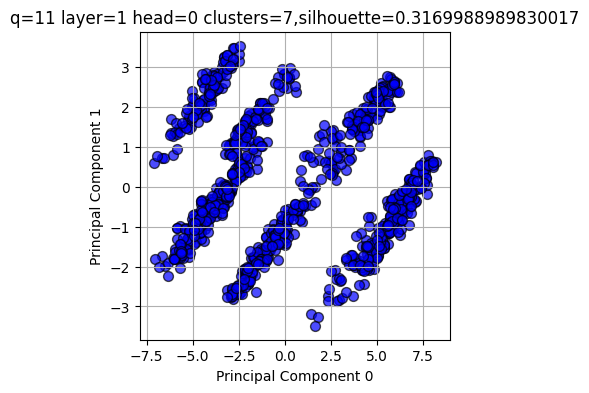

Explained variance by component: [49. 24. 12.  8.  3.  2.  1.  1.  0.  0.]


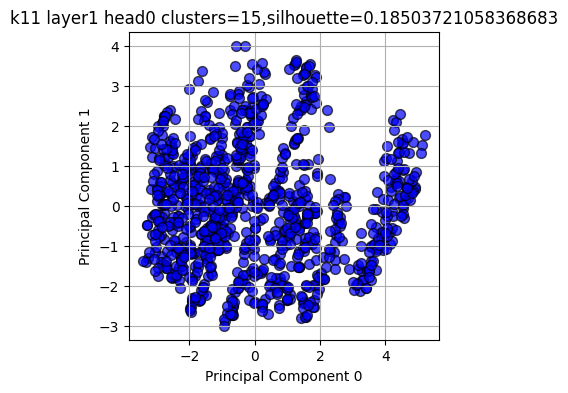

Explained variance by component: [52.999996 39.        4.        2.        1.        1.        0.
  0.        0.        0.      ]


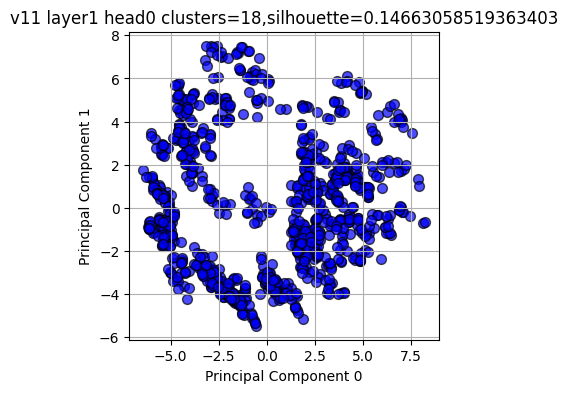

Explained variance by component: [71. 14.  6.  4.  2.  1.  1.  0.  0.  0.]


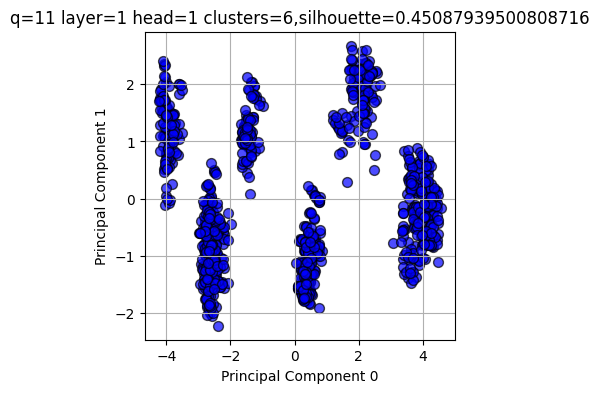

Explained variance by component: [38. 32. 12.  7.  4.  2.  1.  1.  1.  0.]


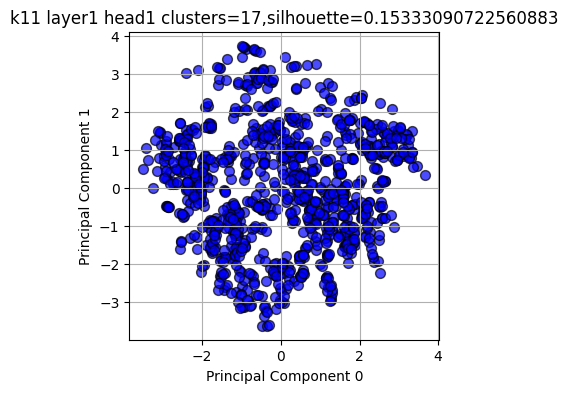

Explained variance by component: [57.       27.000002 12.        2.        1.        1.        0.
  0.        0.        0.      ]


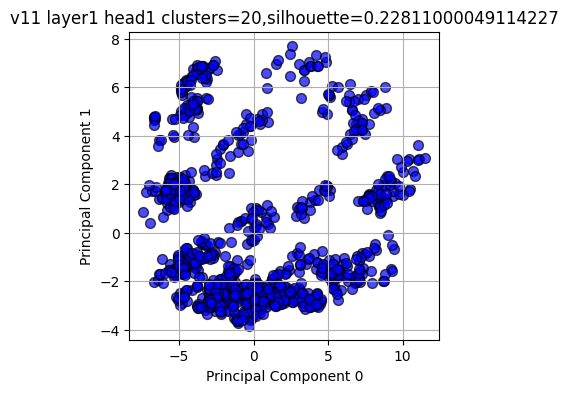

Explained variance by component: [83.  7.  4.  2.  1.  0.  0.  0.  0.  0.]


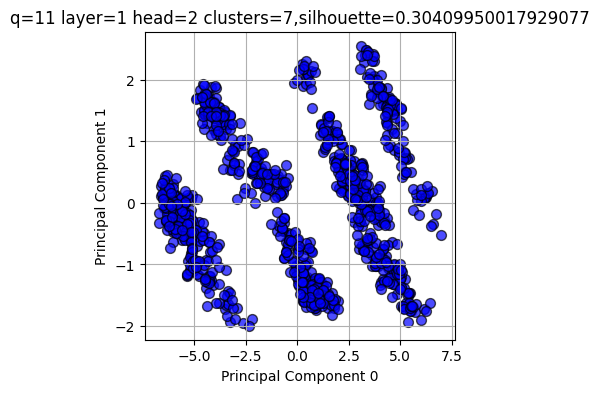

Explained variance by component: [43.       23.       15.000001  7.        6.        2.        1.
  1.        1.        0.      ]


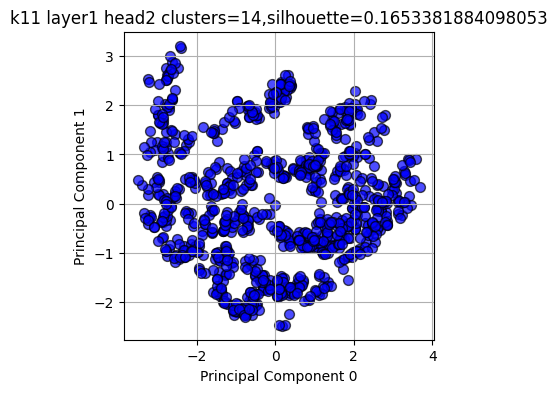

Explained variance by component: [70. 26.  1.  1.  0.  0.  0.  0.  0.  0.]


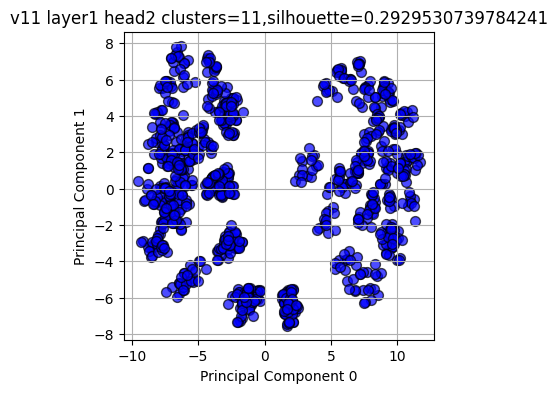

Explained variance by component: [51. 16. 10.  9.  4.  4.  1.  1.  1.  1.]


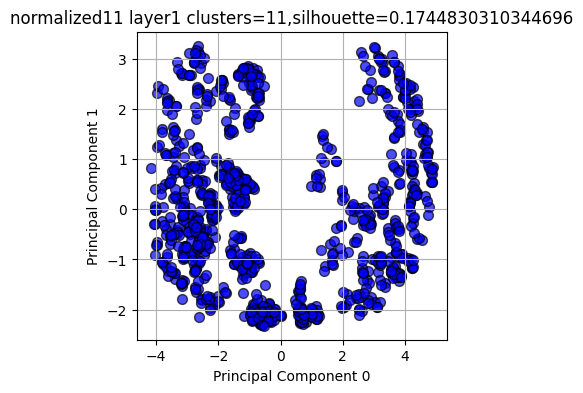

Explained variance by component: [51.       15.000001 10.       10.        5.        4.        1.
  1.        1.        1.      ]


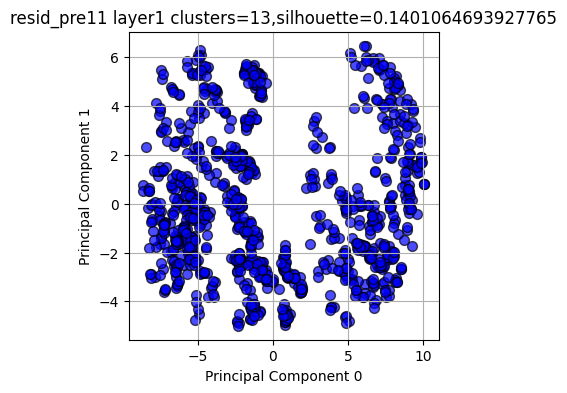

seq=11 max silhouette_avg 0.45087939500808716 resid_pre=0.1401064693927765
Explained variance by component: [84.  7.  3.  2.  1.  1.  0.  0.  0.  0.]


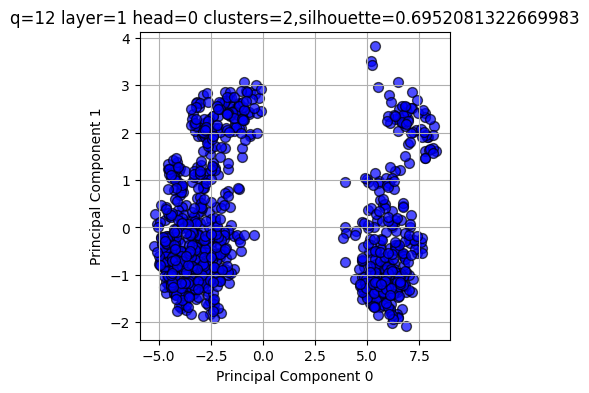

Explained variance by component: [52.999996 22.       10.        8.        2.        1.        1.
  0.        0.        0.      ]


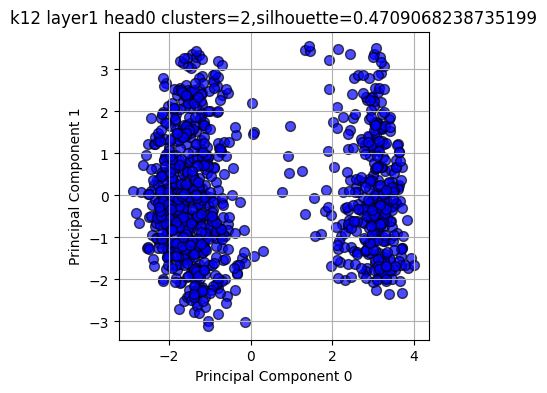

Explained variance by component: [60.000004 31.        5.        1.        1.        0.        0.
  0.        0.        0.      ]


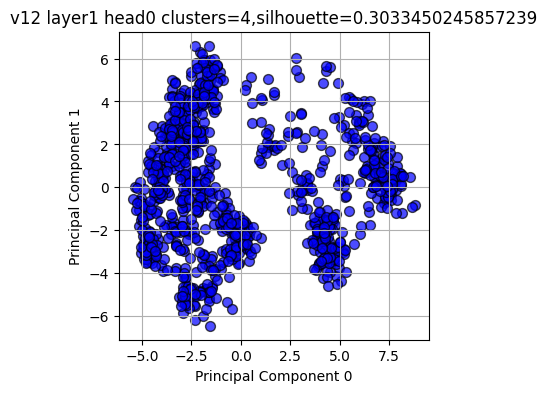

Explained variance by component: [80.  9.  4.  3.  2.  1.  1.  0.  0.  0.]


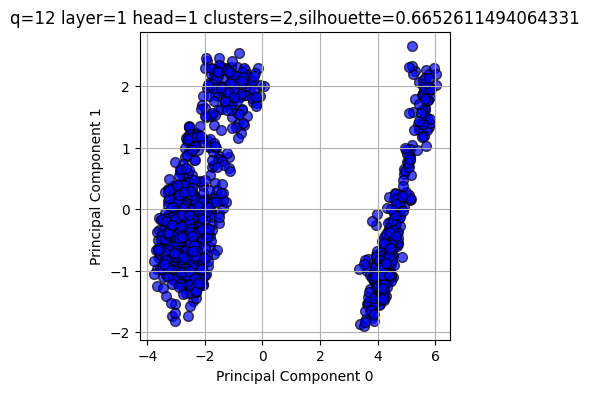

Explained variance by component: [51. 21. 14.  5.  3.  2.  1.  1.  1.  0.]


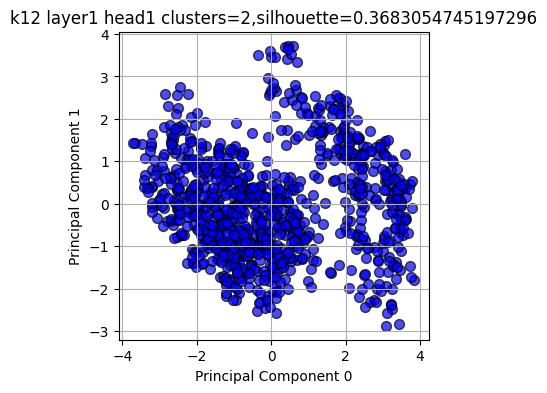

Explained variance by component: [52.999996 33.        7.        3.        1.        1.        0.
  0.        0.        0.      ]


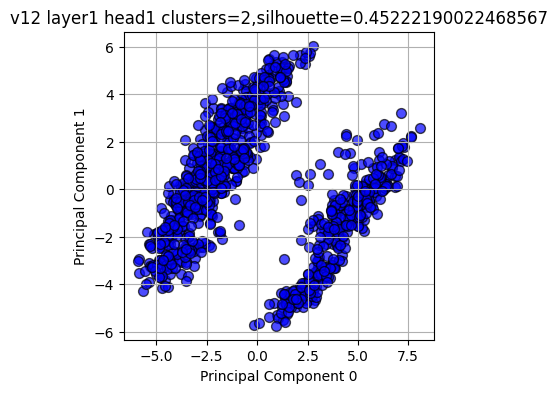

Explained variance by component: [88.  5.  3.  2.  1.  0.  0.  0.  0.  0.]


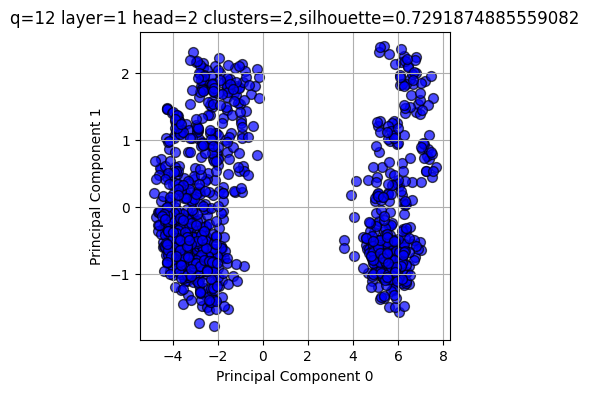

Explained variance by component: [64. 16.  6.  4.  3.  2.  2.  1.  1.  0.]


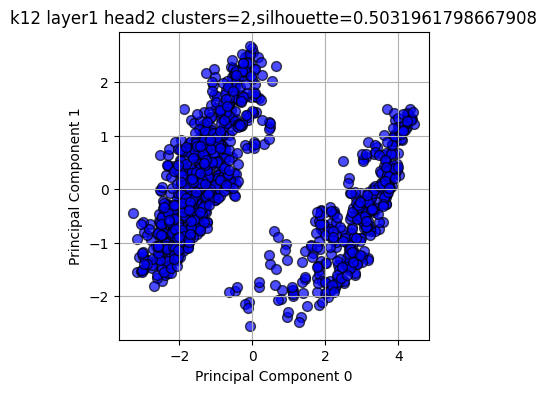

Explained variance by component: [76. 21.  1.  1.  0.  0.  0.  0.  0.  0.]


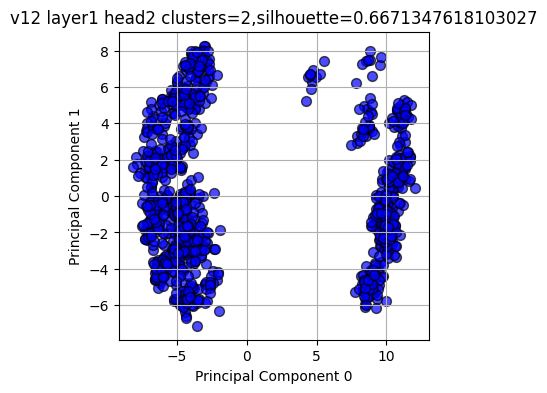

Explained variance by component: [63. 14.  7.  6.  4.  2.  1.  1.  1.  0.]


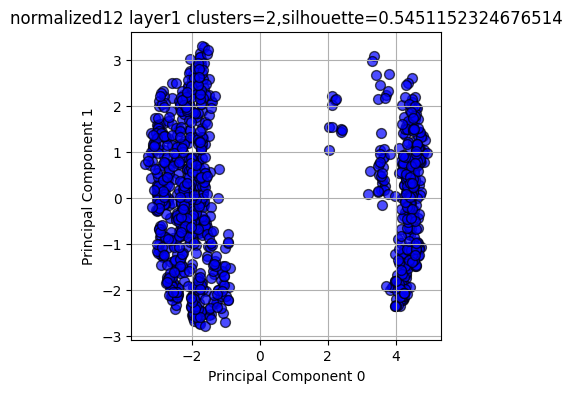

Explained variance by component: [62. 14.  7.  5.  4.  2.  1.  1.  1.  0.]


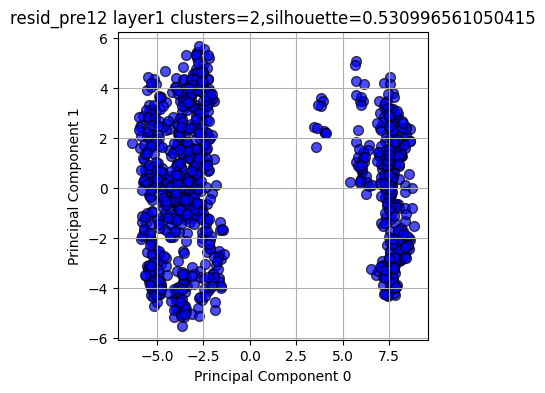

seq=12 max silhouette_avg 0.7291874885559082 resid_pre=0.530996561050415


In [109]:
for seq in [11,12]:
    msa = -1
    layer = 1
    for head in range(3) :
        points =  cluster_state.ctrl_cache["q" , layer][:, seq, head, :]  
        cluster_labels, n_clusters, silhouette_avg = find_clusters(points)
        pca_the_points(points, n_components=10, graph=False,labels=None,title=f"q={seq} layer={layer} head={head} clusters={n_clusters},silhouette={silhouette_avg}")
        msa = max(msa,silhouette_avg)

        points =  cluster_state.ctrl_cache["k" , layer][:, seq, head, :]
        cluster_labels, n_clusters, silhouette_avg = find_clusters(points)
        pca_the_points(points, n_components=10, graph=False,labels=None,title=f"k{seq} layer{layer} head{head} clusters={n_clusters},silhouette={silhouette_avg}")
        msa = max(msa,silhouette_avg)

        points =  cluster_state.ctrl_cache["v" , layer ][:, seq, head, :]
        cluster_labels, n_clusters, silhouette_avg = find_clusters(points)
        pca_the_points(points, n_components=10, graph=False,labels=None,title=f"v{seq} layer{layer} head{head} clusters={n_clusters},silhouette={silhouette_avg}")
        msa = max(msa,silhouette_avg)

    points =  cluster_state.ctrl_cache["normalized" , layer, "ln1"][:, seq, 0, :]
    cluster_labels, n_clusters, silhouette_avg = find_clusters(points)
    pca_the_points(points, n_components=10, graph=False,labels=None,title=f"normalized{seq} layer{layer} clusters={n_clusters},silhouette={silhouette_avg}")
    msa = max(msa,silhouette_avg)

    points =  cluster_state.ctrl_cache["resid_pre" , layer ][:, seq,:]
    cluster_labels, n_clusters, silhouette_avg = find_clusters(points)
    pca_the_points(points, n_components=10, graph=False,labels=None,title=f"resid_pre{seq} layer{layer} clusters={n_clusters},silhouette={silhouette_avg}")
    print(f"seq={seq} max silhouette_avg {msa} resid_pre={silhouette_avg}")